# 🎯 Simple 2D Anomaly Detection Tutorial

## **Gaussian Multivariate Anomaly Detection**

### **Main Goal:**
Learn to detect anomalies in 2D industrial data using a simple Gaussian multivariate method. This tutorial demonstrates how to identify abnormal operating conditions using statistical modeling with easy-to-visualize 2D data.

### **Key Learning Objectives:**
- **2D Data Visualization**: Understand anomaly patterns in 2D space
- **Gaussian Distribution**: Model normal behavior with multivariate Gaussian
- **Probability Contours**: Visualize confidence regions for normal operation
- **Threshold Selection**: Choose optimal detection thresholds
- **Industrial Applications**: Apply to temperature-pressure monitoring systems

### **Why 2D?**
- **Easy Visualization**: See anomalies directly on scatter plots
- **Clear Understanding**: Intuitive grasp of normal vs abnormal regions
- **Real Applications**: Many industrial processes have 2 key variables

### **Dataset**: 
Industrial Process with 2 sensors:
- **Temperature (°C)**: Process operating temperature  
- **Pressure (Bar)**: System pressure

---

## 1. Import Required Libraries

We'll use basic libraries for 2D anomaly detection and visualization.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import multivariate_normal
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import pandas as pd
import ipywidgets as widgets
from ipywidgets import interact

plt.style.use('seaborn-v0_8')
np.random.seed(42)
%matplotlib widget

print("Libraries imported successfully!")
print("Ready for 2D anomaly detection tutorial")

Libraries imported successfully!
Ready for 2D anomaly detection tutorial


## 2. Generate 2D Industrial Dataset

Let's create a simple 2D dataset with temperature and pressure measurements.

In [2]:
def generate_2d_industrial_data(n_normal=500, n_anomalies=50, random_state=42):
    """
    Generate 2D industrial process data:
    - Temperature (°C): Process operating temperature
    - Pressure (Bar): System pressure
    """
    np.random.seed(random_state)
    
    # Normal operation: Temperature ~ 75°C, Pressure ~ 2.5 Bar
    normal_mean = np.array([75.0, 2.5])
    
    # Covariance matrix (temperature and pressure are slightly correlated)
    normal_cov = np.array([[9.0, 0.5],   # Temperature variance = 9, correlation with pressure
                          [0.5, 2.0]])  # Pressure variance = 0.25
    
    # Generate normal data
    normal_data = np.random.multivariate_normal(normal_mean, normal_cov, n_normal)
    
    # Generate different types of anomalies
    anomalies = []
    
    # Type 1: High temperature (overheating)
    n_hot = n_anomalies // 3
    hot_data = np.random.multivariate_normal([90, 2.8], [[4, 0.5], [0.5, 0.16]], n_hot)
    anomalies.append(hot_data)
    
    # Type 2: High pressure (pressure surge)
    n_pressure = n_anomalies // 3
    pressure_data = np.random.multivariate_normal([77, 7.0], [[4, -0.5], [-0.5, 0.25]], n_pressure)
    anomalies.append(pressure_data)
    
    # Type 3: Low temperature + low pressure (shutdown condition)
    n_low = n_anomalies - n_hot - n_pressure
    low_data = np.random.multivariate_normal([60, 1.5], [[9, 0.8], [0.8, 0.16]], n_low)
    anomalies.append(low_data)
    
    # Combine all data
    if anomalies:
        anomaly_data = np.vstack(anomalies)
        X = np.vstack([normal_data, anomaly_data])
        y = np.hstack([np.zeros(n_normal), np.ones(n_anomalies)])
    else:
        X = normal_data
        y = np.zeros(n_normal)
    
    # Create labels
    labels = ['Normal'] * n_normal
    if n_anomalies > 0:
        labels.extend(['High_Temp'] * n_hot + ['High_Pressure'] * n_pressure + ['Low_Temp_Pressure'] * n_low)
    
    # Create DataFrame
    df = pd.DataFrame(X, columns=['Temperature_C', 'Pressure_Bar'])
    df['is_anomaly'] = y
    df['anomaly_type'] = labels
    
    return df, X, y

# Generate the 2D dataset
print("Generating 2D Industrial Process Dataset...")
df, X, y = generate_2d_industrial_data(n_normal=500, n_anomalies=50)

print(f"\nDataset created successfully!")
print(f"Total samples: {len(df)}")
print(f"Normal samples: {(y == 0).sum()}")
print(f"Anomalous samples: {(y == 1).sum()}")
print(f"Anomaly rate: {(y == 1).mean()*100:.1f}%")

print("\nFirst 5 rows:")
display(df.head())

print("\nDataset statistics:")
display(df[['Temperature_C', 'Pressure_Bar']].describe())

print("\nAnomaly type distribution:")
print(df['anomaly_type'].value_counts())

Generating 2D Industrial Process Dataset...

Dataset created successfully!
Total samples: 550
Normal samples: 500
Anomalous samples: 50
Anomaly rate: 9.1%

First 5 rows:


,Temperature_C,Pressure_Bar,is_anomaly,anomaly_type
0,73.524413,2.200854,0.0,Normal
1,72.906676,4.491286,0.0,Normal
2,75.725338,2.222556,0.0,Normal
3,70.188710,3.236417,0.0,Normal
4,76.353743,3.358574,0.0,Normal



Dataset statistics:


,Temperature_C,Pressure_Bar
count,550.000000,550.000000
mean,74.921997,2.645952
std,4.592648,1.559537
min,55.475323,-0.792368
25%,73.061800,1.525416
50%,74.934121,2.523769
75%,77.038556,3.526275
max,91.321626,7.974569



Anomaly type distribution:
anomaly_type
Normal               500
Low_Temp_Pressure     18
High_Temp             16
High_Pressure         16
Name: count, dtype: int64


## 3. Visualize the 2D Data

Let's plot the 2D data to see the normal operating region and anomalies.

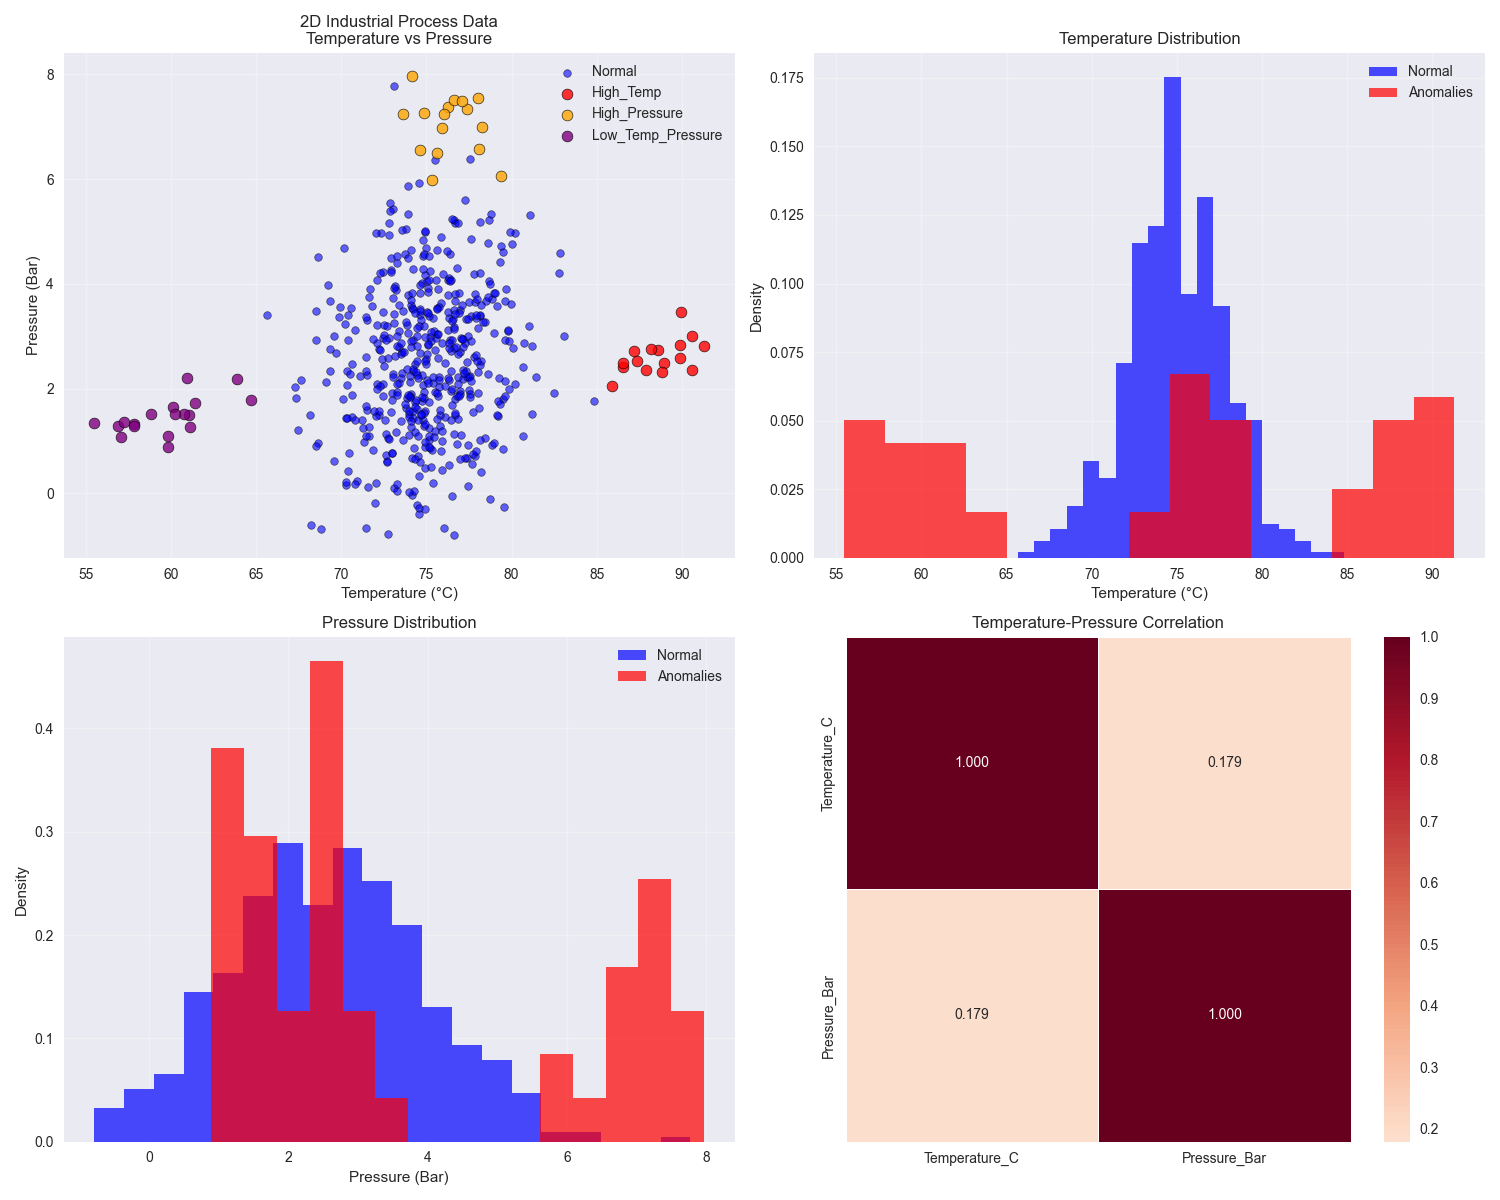

KEY OBSERVATIONS:
✅ Normal operation centers around 75°C and 2.5 Bar
🔥 High temperature anomalies: ~90°C
💨 High pressure anomalies: ~4.0 Bar
❄️ Low temperature-pressure anomalies: ~60°C, 1.5 Bar
🔗 Temperature-Pressure correlation: 0.179


In [3]:
# Create a comprehensive visualization of the 2D data
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(7, 6))

# Color map for different anomaly types
colors = {'Normal': 'blue', 'High_Temp': 'red', 'High_Pressure': 'orange', 'Low_Temp_Pressure': 'purple'}

# 1. Main scatter plot with all data points
for anomaly_type in df['anomaly_type'].unique():
    mask = df['anomaly_type'] == anomaly_type
    data_subset = df[mask]
    
    alpha = 0.6 if anomaly_type == 'Normal' else 0.8
    size = 30 if anomaly_type == 'Normal' else 60
    
    ax1.scatter(data_subset['Temperature_C'], data_subset['Pressure_Bar'],
              c=colors[anomaly_type], label=anomaly_type, 
              alpha=alpha, s=size, edgecolors='black', linewidth=0.5)

ax1.set_xlabel('Temperature (°C)')
ax1.set_ylabel('Pressure (Bar)')
ax1.set_title('2D Industrial Process Data\nTemperature vs Pressure')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Temperature distribution
normal_temp = df[df['is_anomaly'] == 0]['Temperature_C']
anomaly_temp = df[df['is_anomaly'] == 1]['Temperature_C']

ax2.hist(normal_temp, bins=20, alpha=0.7, label='Normal', color='blue', density=True)
ax2.hist(anomaly_temp, bins=15, alpha=0.7, label='Anomalies', color='red', density=True)
ax2.set_xlabel('Temperature (°C)')
ax2.set_ylabel('Density')
ax2.set_title('Temperature Distribution')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Pressure distribution
normal_pressure = df[df['is_anomaly'] == 0]['Pressure_Bar']
anomaly_pressure = df[df['is_anomaly'] == 1]['Pressure_Bar']

ax3.hist(normal_pressure, bins=20, alpha=0.7, label='Normal', color='blue', density=True)
ax3.hist(anomaly_pressure, bins=15, alpha=0.7, label='Anomalies', color='red', density=True)
ax3.set_xlabel('Pressure (Bar)')
ax3.set_ylabel('Density')
ax3.set_title('Pressure Distribution')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Correlation analysis
correlation = df[['Temperature_C', 'Pressure_Bar']].corr()
sns.heatmap(correlation, annot=True, cmap='RdBu_r', center=0,
            fmt='.3f', square=True, linewidths=0.5, ax=ax4)
ax4.set_title('Temperature-Pressure Correlation')

plt.tight_layout()
plt.show()

print("KEY OBSERVATIONS:")
print("=" * 50)
print("✅ Normal operation centers around 75°C and 2.5 Bar")
print("🔥 High temperature anomalies: ~90°C")
print("💨 High pressure anomalies: ~4.0 Bar")
print("❄️ Low temperature-pressure anomalies: ~60°C, 1.5 Bar")
print(f"🔗 Temperature-Pressure correlation: {correlation.iloc[0,1]:.3f}")

## 4. Gaussian Multivariate Anomaly Detection

Now let's implement the Gaussian multivariate method to detect anomalies.

In [4]:
class GaussianAnomalyDetector:
    """
    Simple Gaussian Multivariate Anomaly Detector for 2D data
    """
    
    def __init__(self):
        self.mean = None
        self.cov = None
        self.distribution = None
        
    def fit(self, X_normal):
        """
        Fit the Gaussian model to normal data only
        """
        # Calculate mean and covariance matrix from normal data
        self.mean = np.mean(X_normal, axis=0)
        self.cov = np.cov(X_normal, rowvar=False)
        
        # Add small regularization to ensure positive definite covariance
        reg_param = 1e-6
        self.cov += reg_param * np.eye(self.cov.shape[0])
        
        # Create the multivariate normal distribution
        self.distribution = multivariate_normal(mean=self.mean, cov=self.cov)
        
        print(f"Gaussian model fitted:")
        print(f"  Mean: [{self.mean[0]:.2f}, {self.mean[1]:.2f}]")
        print(f"  Covariance matrix:")
        print(f"    [[{self.cov[0,0]:.3f}, {self.cov[0,1]:.3f}],")
        print(f"     [{self.cov[1,0]:.3f}, {self.cov[1,1]:.3f}]]")
    
    def get_probabilities(self, X):
        """
        Get probability density values for data points
        """
        return self.distribution.pdf(X)
    
    def get_anomaly_scores(self, X):
        """
        Get anomaly scores (lower probability = higher anomaly score)
        """
        probabilities = self.get_probabilities(X)
        # Use negative log probability as anomaly score
        return -np.log(probabilities + 1e-10)  # Add small value to avoid log(0)
    
    def predict(self, X, threshold):
        """
        Predict anomalies based on threshold
        """
        anomaly_scores = self.get_anomaly_scores(X)
        return (anomaly_scores > threshold).astype(int)

# Separate normal data for training (unsupervised approach)
X_normal = X[y == 0]  # Only normal data
X_test = X  # All data for testing
y_test = y  # All labels for testing

print("DATA PREPARATION:")
print("=" * 30)
print(f"Training data (normal only): {X_normal.shape[0]} samples")
print(f"Test data (normal + anomalies): {X_test.shape[0]} samples")
print(f"Test anomaly rate: {(y_test == 1).mean()*100:.1f}%")

# Train the Gaussian anomaly detector
print("\nTRAINING GAUSSIAN ANOMALY DETECTOR:")
print("=" * 40)

detector = GaussianAnomalyDetector()
detector.fit(X_normal)

# Get anomaly scores for all test data
anomaly_scores = detector.get_anomaly_scores(X_test)
probabilities = detector.get_probabilities(X_test)

print(f"\n✅ Model trained successfully!")
print(f"Anomaly scores range: [{anomaly_scores.min():.3f}, {anomaly_scores.max():.3f}]")
print(f"Probability range: [{probabilities.min():.6f}, {probabilities.max():.6f}]")

DATA PREPARATION:
Training data (normal only): 500 samples
Test data (normal + anomalies): 550 samples
Test anomaly rate: 9.1%

TRAINING GAUSSIAN ANOMALY DETECTOR:
Gaussian model fitted:
  Mean: [74.99, 2.55]
  Covariance matrix:
    [[8.402, 0.566],
     [0.566, 1.981]]

✅ Model trained successfully!
Anomaly scores range: [3.234, 22.970]
Probability range: [0.000000, 0.039391]


## 5. Visualize Gaussian Model and Probability Contours

Let's visualize the fitted Gaussian model with probability contours.

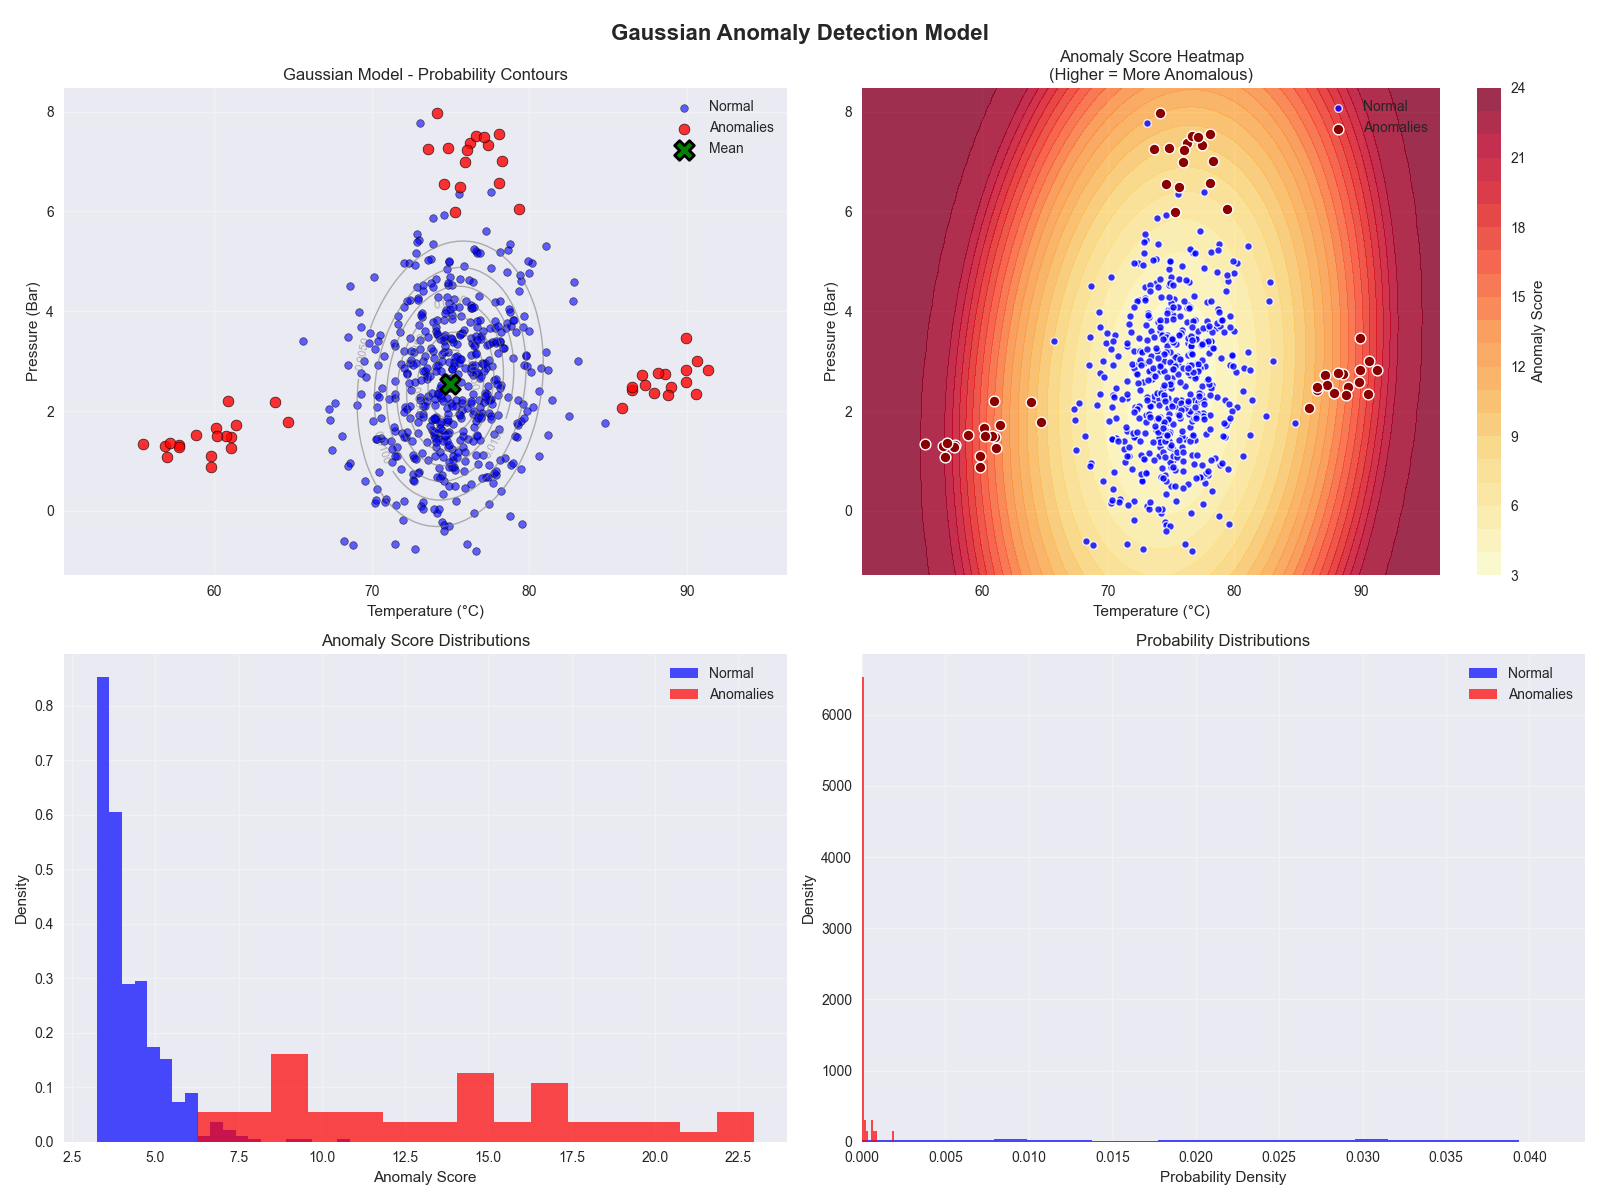

GAUSSIAN MODEL VISUALIZATION:
📊 Top-left: Probability contours show confidence regions
🔥 Top-right: Anomaly score heatmap (red = high anomaly score)
📈 Bottom-left: Score distributions (normal vs anomalous)
📉 Bottom-right: Probability distributions

💡 Key Insight: Anomalies have low probability and high anomaly scores


In [5]:
# Create visualization of the Gaussian model with contours
def plot_gaussian_model(detector, X, y, title="Gaussian Anomaly Detection Model"):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(8, 6))
    
    # Create a grid for contour plotting
    temp_range = np.linspace(X[:, 0].min() - 5, X[:, 0].max() + 5, 100)
    pressure_range = np.linspace(X[:, 1].min() - 0.5, X[:, 1].max() + 0.5, 100)
    temp_grid, pressure_grid = np.meshgrid(temp_range, pressure_range)
    grid_points = np.column_stack([temp_grid.ravel(), pressure_grid.ravel()])
    
    # Calculate probabilities for the grid
    grid_probabilities = detector.get_probabilities(grid_points)
    grid_probs_2d = grid_probabilities.reshape(temp_grid.shape)
    
    # 1. Probability contours with data points
    contours = ax1.contour(temp_grid, pressure_grid, grid_probs_2d, 
                          levels=8, colors='gray', alpha=0.6, linewidths=1)
    ax1.clabel(contours, inline=True, fontsize=8, fmt='%.4f')
    
    # Plot data points
    normal_mask = y == 0
    anomaly_mask = y == 1
    
    ax1.scatter(X[normal_mask, 0], X[normal_mask, 1], 
               c='blue', alpha=0.6, s=30, label='Normal', edgecolors='black', linewidth=0.5)
    ax1.scatter(X[anomaly_mask, 0], X[anomaly_mask, 1], 
               c='red', alpha=0.8, s=60, label='Anomalies', edgecolors='black', linewidth=0.5)
    
    # Mark the center (mean)
    ax1.scatter(detector.mean[0], detector.mean[1], 
               c='green', s=200, marker='X', label='Mean', edgecolors='black', linewidth=2)
    
    ax1.set_xlabel('Temperature (°C)')
    ax1.set_ylabel('Pressure (Bar)')
    ax1.set_title('Gaussian Model - Probability Contours')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Anomaly scores heatmap
    grid_anomaly_scores = detector.get_anomaly_scores(grid_points)
    grid_scores_2d = grid_anomaly_scores.reshape(temp_grid.shape)
    
    heatmap = ax2.contourf(temp_grid, pressure_grid, grid_scores_2d, 
                          levels=20, cmap='YlOrRd', alpha=0.8)
    fig.colorbar(heatmap, ax=ax2, label='Anomaly Score')
    
    # Plot data points
    ax2.scatter(X[normal_mask, 0], X[normal_mask, 1], 
               c='blue', alpha=0.8, s=30, label='Normal', edgecolors='white', linewidth=1)
    ax2.scatter(X[anomaly_mask, 0], X[anomaly_mask, 1], 
               c='darkred', alpha=1.0, s=60, label='Anomalies', edgecolors='white', linewidth=1)
    
    ax2.set_xlabel('Temperature (°C)')
    ax2.set_ylabel('Pressure (Bar)')
    ax2.set_title('Anomaly Score Heatmap\n(Higher = More Anomalous)')
    ax2.legend()
    
    # 3. Anomaly score distributions
    normal_scores = anomaly_scores[y == 0]
    anomaly_scores_subset = anomaly_scores[y == 1]
    
    ax3.hist(normal_scores, bins=20, alpha=0.7, label='Normal', color='blue', density=True)
    ax3.hist(anomaly_scores_subset, bins=15, alpha=0.7, label='Anomalies', color='red', density=True)
    ax3.set_xlabel('Anomaly Score')
    ax3.set_ylabel('Density')
    ax3.set_title('Anomaly Score Distributions')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Probability distributions
    normal_probs = probabilities[y == 0]
    anomaly_probs = probabilities[y == 1]
    
    ax4.hist(normal_probs, bins=20, alpha=0.7, label='Normal', color='blue', density=True)
    ax4.hist(anomaly_probs, bins=15, alpha=0.7, label='Anomalies', color='red', density=True)
    ax4.set_xlabel('Probability Density')
    ax4.set_ylabel('Density')
    ax4.set_title('Probability Distributions')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    ax4.set_xlim(0, max(probabilities) * 1.1)
    
    plt.suptitle(title, fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Plot the Gaussian model
plot_gaussian_model(detector, X_test, y_test)

print("GAUSSIAN MODEL VISUALIZATION:")
print("=" * 40)
print("📊 Top-left: Probability contours show confidence regions")
print("🔥 Top-right: Anomaly score heatmap (red = high anomaly score)")
print("📈 Bottom-left: Score distributions (normal vs anomalous)")
print("📉 Bottom-right: Probability distributions")
print("\n💡 Key Insight: Anomalies have low probability and high anomaly scores")

## 6. Interactive Threshold Explorer

Let's create an interactive tool to explore how different thresholds affect anomaly detection.

In [ ]:
def interactive_2d_threshold_explorer(threshold_percentile=90):
    """
    Interactive exploration of thresholds in 2D space
    """
    # Calculate threshold based on percentile
    threshold = np.percentile(anomaly_scores, threshold_percentile)
    
    # Make predictions
    y_pred = detector.predict(X_test, threshold)
    
    # Calculate metrics
    cm = confusion_matrix(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    
    # Create comprehensive visualization
    fig = plt.figure(figsize=(9, 6))
    
    # 1. 2D scatter plot with decision boundary
    ax1 = plt.subplot(2, 3, 1)
    
    # Create grid for decision boundary
    temp_range = np.linspace(X_test[:, 0].min() - 3, X_test[:, 0].max() + 3, 150)
    pressure_range = np.linspace(X_test[:, 1].min() - 0.3, X_test[:, 1].max() + 0.3, 150)
    temp_grid, pressure_grid = np.meshgrid(temp_range, pressure_range)
    grid_points = np.column_stack([temp_grid.ravel(), pressure_grid.ravel()])
    
    # Calculate scores for grid
    grid_scores = detector.get_anomaly_scores(grid_points)
    grid_scores_2d = grid_scores.reshape(temp_grid.shape)
    
    # Plot decision boundary
    decision_boundary = ax1.contour(temp_grid, pressure_grid, grid_scores_2d, 
                                   levels=[threshold], colors=['black'], linewidths=3)
    ax1.clabel(decision_boundary, inline=True, fontsize=10, fmt=f'Threshold: {threshold:.2f}')
    
    # Plot background regions
    ax1.contourf(temp_grid, pressure_grid, grid_scores_2d, 
                levels=[0, threshold, grid_scores.max()], 
                colors=['lightblue', 'lightcoral'], alpha=0.3)
    
    # Plot actual data points with prediction colors
    correct_normal = (y_test == 0) & (y_pred == 0)
    correct_anomaly = (y_test == 1) & (y_pred == 1)
    false_positive = (y_test == 0) & (y_pred == 1)
    false_negative = (y_test == 1) & (y_pred == 0)
    
    ax1.scatter(X_test[correct_normal, 0], X_test[correct_normal, 1], 
               c='blue', s=40, alpha=0.7, label='True Negative', edgecolors='black', linewidth=0.5)
    ax1.scatter(X_test[correct_anomaly, 0], X_test[correct_anomaly, 1], 
               c='red', s=60, alpha=0.9, label='True Positive', edgecolors='black', linewidth=0.5)
    ax1.scatter(X_test[false_positive, 0], X_test[false_positive, 1], 
               c='orange', s=80, alpha=0.9, label='False Positive', marker='^', edgecolors='black', linewidth=1)
    ax1.scatter(X_test[false_negative, 0], X_test[false_negative, 1], 
               c='purple', s=80, alpha=0.9, label='False Negative', marker='s', edgecolors='black', linewidth=1)
    
    ax1.set_xlabel('Temperature (°C)')
    ax1.set_ylabel('Pressure (Bar)')
    ax1.set_title(f'2D Decision Boundary\nThreshold: {threshold:.3f} ({threshold_percentile}th percentile)')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.grid(True, alpha=0.3)
    
    # 2. Confusion Matrix
    ax2 = plt.subplot(2, 3, 2)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax2,
               xticklabels=['Normal', 'Anomaly'],
               yticklabels=['Normal', 'Anomaly'])
    ax2.set_title(f'Confusion Matrix')
    ax2.set_xlabel('Predicted')
    ax2.set_ylabel('Actual')
    
    # 3. Metrics bar chart
    ax3 = plt.subplot(2, 3, 3)
    metrics = ['Precision', 'Recall', 'F1-Score']
    values = [precision, recall, f1]
    colors_metrics = ['skyblue', 'lightcoral', 'lightgreen']
    
    bars = ax3.bar(metrics, values, color=colors_metrics, edgecolor='black', linewidth=1)
    ax3.set_ylim(0, 1)
    ax3.set_title('Performance Metrics')
    ax3.set_ylabel('Score')
    ax3.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bar, value in zip(bars, values):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{value:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # 4. Anomaly score distribution with threshold
    ax4 = plt.subplot(2, 3, 4)
    normal_scores = anomaly_scores[y_test == 0]
    anomaly_scores_subset = anomaly_scores[y_test == 1]
    
    ax4.hist(normal_scores, bins=25, alpha=0.7, label='Normal', color='blue', density=True)
    ax4.hist(anomaly_scores_subset, bins=15, alpha=0.7, label='Anomalies', color='red', density=True)
    ax4.axvline(threshold, color='black', linestyle='--', linewidth=3, 
               label=f'Threshold: {threshold:.3f}')
    ax4.set_xlabel('Anomaly Score')
    ax4.set_ylabel('Density')
    ax4.set_title('Score Distribution with Threshold')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # 5. Prediction breakdown pie chart
    ax5 = plt.subplot(2, 3, 5)
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
        
        breakdown_labels = ['True Negative\n(Normal→Normal)', 'False Positive\n(Normal→Anomaly)', 
                           'False Negative\n(Anomaly→Normal)', 'True Positive\n(Anomaly→Anomaly)']
        breakdown_values = [tn, fp, fn, tp]
        breakdown_colors = ['lightblue', 'orange', 'purple', 'lightcoral']
        
        wedges, texts, autotexts = ax5.pie(breakdown_values, labels=breakdown_labels, 
                                          colors=breakdown_colors, autopct='%1.0f', 
                                          startangle=90, textprops={'fontsize': 9})
        ax5.set_title('Prediction Breakdown')
    
    # 6. Statistics summary
    ax6 = plt.subplot(2, 3, 6)
    ax6.axis('off')
    
    # Create statistics text
    stats_text = f"""
    DETECTION STATISTICS
    {'='*30}
    
    Threshold: {threshold:.4f}
    Percentile: {threshold_percentile}th
    
    Total Samples: {len(y_test)}
    Predicted Anomalies: {np.sum(y_pred)}
    Actual Anomalies: {np.sum(y_test)}
    
    PERFORMANCE METRICS:
    Precision: {precision:.3f}
    Recall: {recall:.3f}
    F1-Score: {f1:.3f}
    """
    
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        stats_text += f"""
    
    CONFUSION MATRIX:
    True Negatives: {tn}
    False Positives: {fp}
    False Negatives: {fn}
    True Positives: {tp}
    
    False Positive Rate: {fpr:.3f}
        """
    
    ax6.text(0.1, 0.9, stats_text, transform=ax6.transAxes, fontsize=11,
            verticalalignment='top', fontfamily='monospace',
            bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
    
    plt.suptitle(f'2D Gaussian Anomaly Detection - Interactive Analysis\n'
                f'Threshold Percentile: {threshold_percentile}%', 
                fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Create the interactive widget
print("🎮 INTERACTIVE 2D THRESHOLD EXPLORER")
print("=" * 50)
print("Adjust the threshold percentile to see how it affects anomaly detection!")
print("Higher percentile = stricter detection (fewer false positives)")
print("Lower percentile = more sensitive detection (fewer false negatives)")
print()

interact(interactive_2d_threshold_explorer,
         threshold_percentile=widgets.IntSlider(
             value=90,
             min=70,
             max=99,
             step=1,
             description='Threshold %:',
             style={'description_width': 'initial'}
         ));

🎮 INTERACTIVE 2D THRESHOLD EXPLORER
Adjust the threshold percentile to see how it affects anomaly detection!
Higher percentile = stricter detection (fewer false positives)
Lower percentile = more sensitive detection (fewer false negatives)



## 7. Performance Analysis

Let's analyze the performance across different thresholds.

PERFORMANCE ANALYSIS ACROSS THRESHOLDS
Best F1-Score: 0.914
Optimal Threshold: 7.149 (90th percentile)
At optimal threshold:
  Precision: 0.873
  Recall: 0.960
  False Positive Rate: 0.014


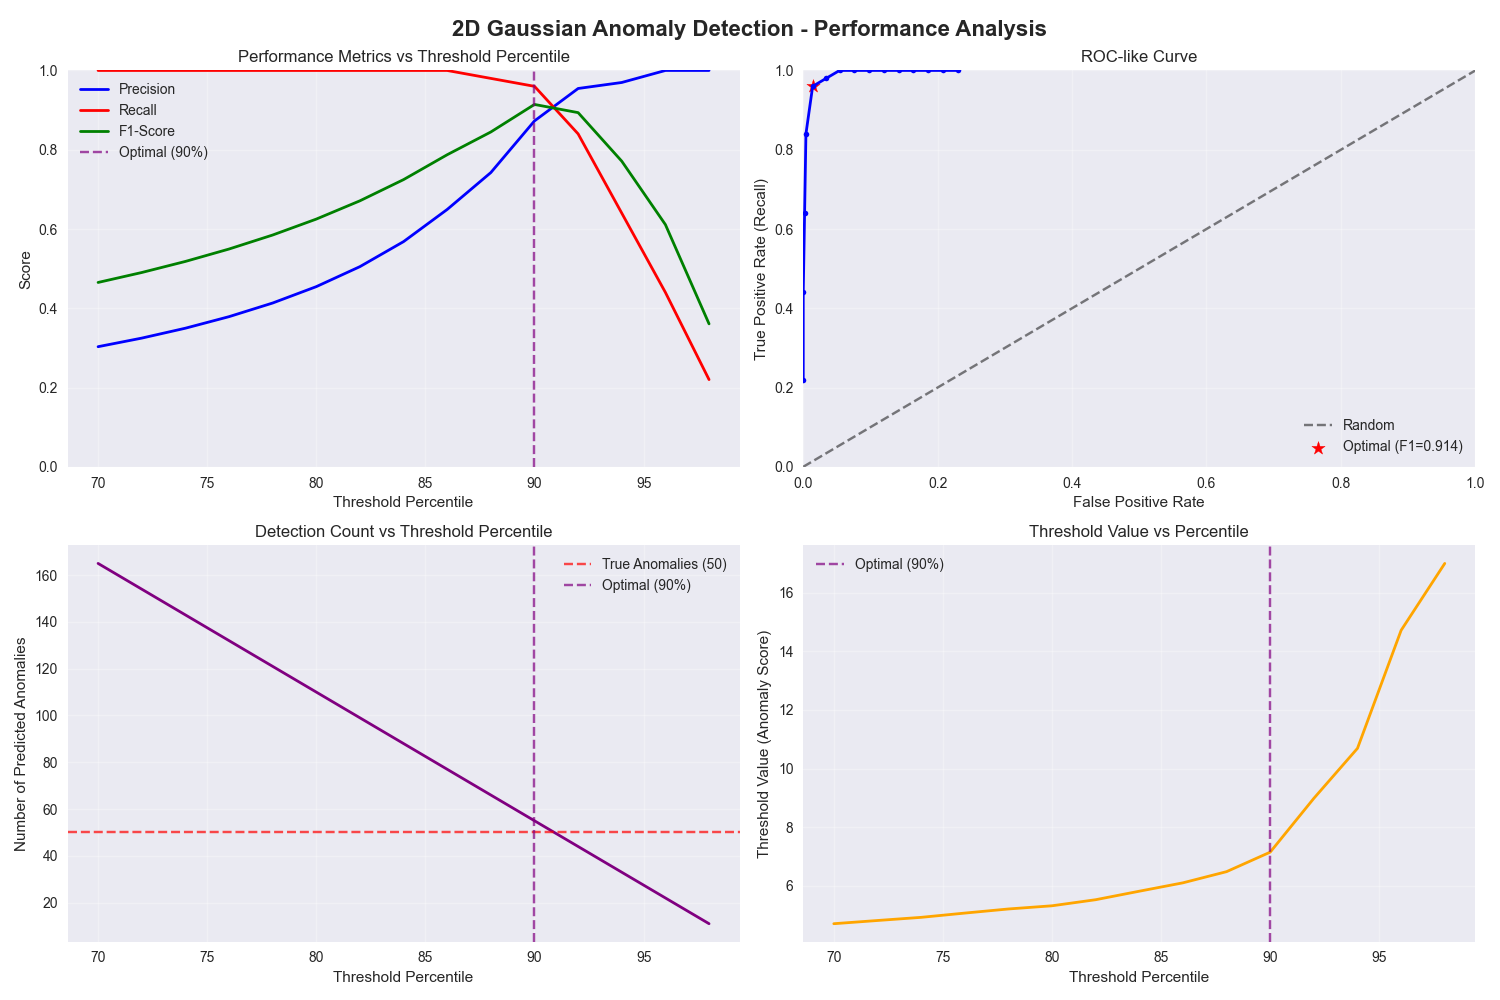


TOP 5 PERFORMANCE RESULTS (by F1-Score):


,percentile,threshold,precision,recall,f1_score,fpr
10,90,7.149,0.873,0.96,0.914,0.014
11,92,8.984,0.955,0.84,0.894,0.004
9,88,6.484,0.742,0.98,0.845,0.034
8,86,6.103,0.649,1.00,0.787,0.054
12,94,10.690,0.970,0.64,0.771,0.002


In [ ]:
# Analyze performance across different thresholds
percentiles = np.arange(70, 100, 2)  # From 70% to 99%
thresholds = [np.percentile(anomaly_scores, p) for p in percentiles]

results = []

for i, (percentile, threshold) in enumerate(zip(percentiles, thresholds)):
    y_pred = detector.predict(X_test, threshold)
    
    # Calculate metrics
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    else:
        if np.all(y_pred == 0):
            tn, fp, fn, tp = np.sum(y_test == 0), 0, np.sum(y_test == 1), 0
        else:
            tn, fp, fn, tp = 0, np.sum(y_test == 0), 0, np.sum(y_test == 1)
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    
    results.append({
        'percentile': percentile,
        'threshold': threshold,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'fpr': fpr,
        'n_predicted_anomalies': np.sum(y_pred),
        'tn': tn, 'fp': fp, 'fn': fn, 'tp': tp
    })

results_df = pd.DataFrame(results)

# Find optimal threshold
best_f1_idx = results_df['f1_score'].idxmax()
optimal_result = results_df.iloc[best_f1_idx]

print("PERFORMANCE ANALYSIS ACROSS THRESHOLDS")
print("=" * 50)
print(f"Best F1-Score: {optimal_result['f1_score']:.3f}")
print(f"Optimal Threshold: {optimal_result['threshold']:.3f} ({optimal_result['percentile']:.0f}th percentile)")
print(f"At optimal threshold:")
print(f"  Precision: {optimal_result['precision']:.3f}")
print(f"  Recall: {optimal_result['recall']:.3f}")
print(f"  False Positive Rate: {optimal_result['fpr']:.3f}")

# Plot performance curves
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(7, 5))

# 1. Metrics vs Percentile
ax1.plot(results_df['percentile'], results_df['precision'], 'b-', linewidth=2, label='Precision')
ax1.plot(results_df['percentile'], results_df['recall'], 'r-', linewidth=2, label='Recall')
ax1.plot(results_df['percentile'], results_df['f1_score'], 'g-', linewidth=2, label='F1-Score')
ax1.axvline(optimal_result['percentile'], color='purple', linestyle='--', alpha=0.7, 
           label=f'Optimal ({optimal_result["percentile"]:.0f}%)')
ax1.set_xlabel('Threshold Percentile')
ax1.set_ylabel('Score')
ax1.set_title('Performance Metrics vs Threshold Percentile')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, 1)

# 2. ROC-like curve (TPR vs FPR)
tpr = results_df['recall']  # True Positive Rate = Recall
fpr_vals = results_df['fpr']  # False Positive Rate

ax2.plot(fpr_vals, tpr, 'bo-', linewidth=2, markersize=4)
ax2.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random')
ax2.scatter(optimal_result['fpr'], optimal_result['recall'], 
           c='red', s=100, marker='*', label=f'Optimal (F1={optimal_result["f1_score"]:.3f})')
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate (Recall)')
ax2.set_title('ROC-like Curve')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)

# 3. Number of detected anomalies
ax3.plot(results_df['percentile'], results_df['n_predicted_anomalies'], 'purple', linewidth=2)
ax3.axhline(y=50, color='red', linestyle='--', alpha=0.7, label='True Anomalies (50)')
ax3.axvline(optimal_result['percentile'], color='purple', linestyle='--', alpha=0.7, 
           label=f'Optimal ({optimal_result["percentile"]:.0f}%)')
ax3.set_xlabel('Threshold Percentile')
ax3.set_ylabel('Number of Predicted Anomalies')
ax3.set_title('Detection Count vs Threshold Percentile')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Threshold values
ax4.plot(results_df['percentile'], results_df['threshold'], 'orange', linewidth=2)
ax4.axvline(optimal_result['percentile'], color='purple', linestyle='--', alpha=0.7, 
           label=f'Optimal ({optimal_result["percentile"]:.0f}%)')
ax4.set_xlabel('Threshold Percentile')
ax4.set_ylabel('Threshold Value (Anomaly Score)')
ax4.set_title('Threshold Value vs Percentile')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.suptitle('2D Gaussian Anomaly Detection - Performance Analysis', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Show top 5 results
print("\nTOP 5 PERFORMANCE RESULTS (by F1-Score):")
top_results = results_df.nlargest(5, 'f1_score')[['percentile', 'threshold', 'precision', 'recall', 'f1_score', 'fpr']]
display(top_results.round(3))

## 🎯 Key Takeaways - 2D Gaussian Anomaly Detection

### **What We Learned:**

#### **1. Gaussian Multivariate Method:**
- **Simple & Effective**: Models normal behavior with mean and covariance
- **Probabilistic**: Provides probability estimates for each data point
- **Interpretable**: Easy to understand decision boundaries

#### **2. 2D Visualization Benefits:**
- **Clear Decision Boundary**: See exactly where normal ends and anomaly begins
- **Confidence Contours**: Probability levels show certainty regions
- **Error Analysis**: Visually identify false positives and false negatives

#### **3. Threshold Selection Strategy:**
- **High Percentile (95-99%)**: Conservative - few false alarms, might miss subtle anomalies
- **Medium Percentile (85-90%)**: Balanced - good trade-off for most applications
- **Low Percentile (70-80%)**: Sensitive - catches everything but more false alarms

### **Industrial Applications:**

#### **🏭 Process Monitoring:**
- **Temperature-Pressure Systems**: Boiler monitoring, reactor control
- **Flow-Pressure Systems**: Pipeline monitoring, pump performance
- **Voltage-Current Systems**: Electrical equipment monitoring

#### **⚙️ Equipment Health:**
- **Vibration-Temperature**: Motor and bearing condition monitoring
- **Speed-Load**: Machine performance optimization
- **Efficiency-Output**: Production quality control

### **Method Advantages:**
- ✅ **Fast Training**: Only needs to calculate mean and covariance
- ✅ **Real-time Detection**: Quick probability calculations
- ✅ **No Parameter Tuning**: Minimal hyperparameters to adjust
- ✅ **Probabilistic Output**: Confidence levels for decisions
- ✅ **Easy Interpretation**: Clear statistical meaning

### **Method Limitations:**
- ❌ **Gaussian Assumption**: Normal data must be roughly Gaussian
- ❌ **Linear Decision Boundary**: Can't handle complex, non-linear anomaly patterns
- ❌ **Sensitive to Outliers**: Outliers in training data affect the model
- ❌ **Single Mode**: Assumes normal data has one main cluster

### **Best Practices:**
1. **Data Quality**: Ensure training data is truly "normal" operation
2. **Threshold Tuning**: Use validation data to find optimal threshold
3. **Regular Updates**: Retrain model as normal operation evolves
4. **Visual Inspection**: Always plot data to verify Gaussian assumption
5. **Domain Knowledge**: Use industrial expertise to validate anomaly types

### **When to Use Gaussian Method:**
- 📊 Data approximately follows Gaussian distribution
- 🎯 Need simple, interpretable model
- ⚡ Require fast real-time detection
- 🔧 Limited computational resources
- 👥 Need to explain results to operators

---

**This simplified 2D tutorial provides a solid foundation for understanding anomaly detection principles before moving to more complex, high-dimensional industrial datasets.**